# **NBA Players Individual Pefromance Predictions Using LSTM**

This notebok shows the process of building training and experimenting with a Long Short Term Memory neural network (LSTM), designed for predicting NBA players Performances thorughout a series of games.

**The Motivation:** We're 3 basketball enphusiasts who share a passion for the NBA and take part in Fantasy NBA leagues. Fantasy games are all about trying to predict players performances and build a winning team based on these perdictions. Of course online Fantasy games are just one way in which these predictions might come in handy! Basketball professionals such as scouters managers and coaches might find this tool extremely helpful.

**The Main idea:** Building a network which recieves as input a sequence of N successive game statistics vectors ( [Points, Rebounds, Steals, etc...] ) played by an NBA player, and for each game tries to predict what is the range of the PER (Player Efficiency Rating) score that the player got in the next game.
By trying to predict a range of scores rather than a specific number, we casted this regression problem of as a classification one. We hope this will make our network easier to evaluate and experiment with.

**The logic** behind looking at a sequence of games in order to predict the scores, rather than making a perdiction based on a single game - which is what a simple Feed Forward network would try to accomplish - is simple:
We assume that a player's PER scores in successive games are co-dependent as a player might be in certain shape and therefore achive similar results in those games. This is why using LSTM which is a type of Recurrent Neural Network (RNN) might be well suited to learn these dependencies.

We'll try to confirm this **hypothesis** by building a simple Feed Forward network as well and comparing the Results.

# **Dataset Building**

We couldn't find a proper dataset containing individual players performance history, so we decided to build one on our own.
We used an open source project - [basketball-reference-scraper](https://pypi.org/project/basketball-reference-scraper/)  - for scraping NBA stats out of [https://www.basketball-reference.com/](https://www.basketball-reference.com/) 

**Scraping Raw Data**

Scraping NBA players individual performances (box-scores) data between 2000-2020

In [0]:
import numpy as np
import pickle
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install basketball-reference-scraper

     |████████████████████████████████| 512kB 38.5MB/s 
     |████████████████████████████████| 20.2MB 160kB/s 
     |████████████████████████████████| 61kB 11.1MB/s 
     |████████████████████████████████| 5.8MB 23.3MB/s 
     |████████████████████████████████| 112kB 62.9MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9
  Found existing installation: numpy 1.18.2


In [0]:
import basketball_reference_scraper as bc
from basketball_reference_scraper.teams import get_roster
from basketball_reference_scraper.players import get_game_logs

In [0]:
# Create Team <-> Index dictionary
teams = ['ATL','SLH','MIL','TCB','BOS','BRK','NJN','CHI','CHO','CHA','CLE','DAL','DEN','DET','FWP','GSW','SFW','CHH',
'PHI','HOU','IND','LAC','SDC','BUF','LAL','MIN','MEM','VAN','MIA','MIL','MIN','NOP','NOK','NOH','NYK','OKC','SEA','ORL','PHI','SYR','PHO',
'POR','SAC','KCK','KCK','CIN','ROR','SAS','TOR','UTA','NOJ','WAS','WAS','CAP','BAL','CHI','CHI','AND','CHI','IND','SRS','SLB','WAS','WAT']

team2idx = {t:i for i,t in enumerate(teams)}
idx2team = {i:t for t,i in team2idx.items()}
print(team2idx)
print(idx2team)

{'ATL': 0, 'SLH': 1, 'MIL': 29, 'TCB': 3, 'BOS': 4, 'BRK': 5, 'NJN': 6, 'CHI': 58, 'CHO': 8, 'CHA': 9, 'CLE': 10, 'DAL': 11, 'DEN': 12, 'DET': 13, 'FWP': 14, 'GSW': 15, 'SFW': 16, 'CHH': 17, 'PHI': 38, 'HOU': 19, 'IND': 59, 'LAC': 21, 'SDC': 22, 'BUF': 23, 'LAL': 24, 'MIN': 30, 'MEM': 26, 'VAN': 27, 'MIA': 28, 'NOP': 31, 'NOK': 32, 'NOH': 33, 'NYK': 34, 'OKC': 35, 'SEA': 36, 'ORL': 37, 'SYR': 39, 'PHO': 40, 'POR': 41, 'SAC': 42, 'KCK': 44, 'CIN': 45, 'ROR': 46, 'SAS': 47, 'TOR': 48, 'UTA': 49, 'NOJ': 50, 'WAS': 62, 'CAP': 53, 'BAL': 54, 'AND': 57, 'SRS': 60, 'SLB': 61, 'WAT': 63}
{0: 'ATL', 1: 'SLH', 29: 'MIL', 3: 'TCB', 4: 'BOS', 5: 'BRK', 6: 'NJN', 58: 'CHI', 8: 'CHO', 9: 'CHA', 10: 'CLE', 11: 'DAL', 12: 'DEN', 13: 'DET', 14: 'FWP', 15: 'GSW', 16: 'SFW', 17: 'CHH', 38: 'PHI', 19: 'HOU', 59: 'IND', 21: 'LAC', 22: 'SDC', 23: 'BUF', 24: 'LAL', 30: 'MIN', 26: 'MEM', 27: 'VAN', 28: 'MIA', 31: 'NOP', 32: 'NOK', 33: 'NOH', 34: 'NYK', 35: 'OKC', 36: 'SEA', 37: 'ORL', 39: 'SYR', 40: 'PHO', 41

In [0]:
# TEST - Scraping a player games history
aldridge_games = bc.players.get_game_logs('LaMarcus Aldridge', '2000-01-01', '2020-03-15')

In [0]:
aldridge_games.drop(columns=['DATE']).head() # we don't really care about the date of the game, everything else is relevent

,AGE,TEAM,HOME/AWAY,OPPONENT,RESULT,GS,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GAME_SCORE,+/-
4,21-116,POR,HOME,DAL,L (-7),0,19:11,5,9,.556,0,0,NaN,0,0,NaN,6,2,8,0,0,0,0,2,10,9.7,+3
5,21-118,POR,AWAY,MIN,L (-12),0,25:09,3,5,.600,0,0,NaN,1,4,.250,0,4,4,1,0,3,0,5,7,5.5,-10
6,21-119,POR,AWAY,CLE,L (-13),0,22:43,5,5,1.000,0,0,NaN,3,4,.750,3,5,8,1,3,0,0,5,13,16.4,+10
7,21-121,POR,AWAY,BOS,L (-28),1,26:49,5,5,1.000,0,0,NaN,2,2,1.000,3,2,5,1,1,0,0,3,12,13.7,-3
8,21-122,POR,AWAY,NJN,W (+18),1,34:04,5,9,.556,0,0,NaN,2,2,1.000,1,2,3,2,1,2,1,4,12,10.2,+20


In [0]:
## Pre-Processing function for a player games history
def process_games_history(player_games):
  player_games_duplicate = player_games.copy()
  player_games_duplicate.drop(columns=["DATE"], inplace=True)

  # Process HOME/AWAY
  player_games_duplicate.replace('HOME', 1, inplace=True)
  player_games_duplicate.replace('AWAY', -1, inplace=True)

  # Process TEAM & OPPONENT
  for team in team2idx.keys():
    player_games_duplicate.replace(team, team2idx[team], inplace=True)

  # Process age
  player_games_duplicate.replace("^((\d\d)-\d*)", "\\2", regex=True, inplace=True)

  # Process Result
  player_games_duplicate.replace("[L,W,(,)]", "", regex=True, inplace=True)

  # Process Minutes Played
  player_games_duplicate.replace("[:]", ".",regex=True, inplace=True)

  # Process NaN Percentage
  player_games_duplicate.replace(np.NaN, 0, inplace=True)

  # Arrange columns similarly for every player
  player_games_duplicate = player_games_duplicate[  ['AGE','TEAM','OPPONENT','HOME/AWAY','GS','MP','FG',
                                                    'FGA','FG%','3P','3PA','3P%','FT','FTA','FT%','ORB','DRB','TRB',
                                                    'AST','STL','BLK','TOV','PF','PTS','RESULT','+/-','GAME_SCORE'] ]

  return player_games_duplicate.astype(float)

In [0]:
# TEST - Process a player's games history
process_games_history(aldridge_games).head()

,AGE,TEAM,OPPONENT,HOME/AWAY,GS,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,RESULT,+/-,GAME_SCORE
4,21.0,41.0,11.0,1.0,0.0,19.11,5.0,9.0,0.556,0.0,0.0,0.0,0.0,0.0,0.00,6.0,2.0,8.0,0.0,0.0,0.0,0.0,2.0,10.0,-7.0,3.0,9.7
5,21.0,41.0,30.0,-1.0,0.0,25.09,3.0,5.0,0.600,0.0,0.0,0.0,1.0,4.0,0.25,0.0,4.0,4.0,1.0,0.0,3.0,0.0,5.0,7.0,-12.0,-10.0,5.5
6,21.0,41.0,10.0,-1.0,0.0,22.43,5.0,5.0,1.000,0.0,0.0,0.0,3.0,4.0,0.75,3.0,5.0,8.0,1.0,3.0,0.0,0.0,5.0,13.0,-13.0,10.0,16.4
7,21.0,41.0,4.0,-1.0,1.0,26.49,5.0,5.0,1.000,0.0,0.0,0.0,2.0,2.0,1.00,3.0,2.0,5.0,1.0,1.0,0.0,0.0,3.0,12.0,-28.0,-3.0,13.7
8,21.0,41.0,6.0,-1.0,1.0,34.04,5.0,9.0,0.556,0.0,0.0,0.0,2.0,2.0,1.00,1.0,2.0,3.0,2.0,1.0,2.0,1.0,4.0,12.0,18.0,20.0,10.2


In [0]:
# TEST - Fetch a roster of a team from a given year
player = list(bc.teams.get_roster('ATL',2000)['PLAYER'])
player

['Drew Barry',
 'Cal Bowdler',
 'Bimbo Coles',
 'Chris Crawford',
 'LaPhonso Ellis',
 'Dion Glover',
 'Alan Henderson',
 'Jim Jackson',
 'Anthony Johnson',
 'Roshown McLeod',
 'Dikembe Mutombo',
 'Isaiah Rider',
 'Jason Terry',
 'Lorenzen Wright']

In [0]:
# A function for getting a team rosters between 2000,2020
def get_team_rosters(team):
  rosters = {}
  for i in range (2000,2021):
    rosters[i] = list(bc.teams.get_roster(team,i)['PLAYER'])

  return rosters

In [0]:
# A function for extracting unique players names from the list of rosters
def get_players(rosters):
  players = set()
  for roster in rosters.values():
    for player in roster:
      players.add(player)

  return list(players)

In [0]:
# Create a list of players between 2000-2021
players = set()

for team in team2idx.keys():
  try:
    rosters = get_team_rosters(team)
    print('fetched players from: ', team)
    for player in get_players(rosters):
      players.add(player)
  except:
    print('unable to fetch players from: ', team)
    continue

unable to fetch players from:  ATL
unable to fetch players from:  SLH
unable to fetch players from:  MIL
unable to fetch players from:  TCB
unable to fetch players from:  BOS
unable to fetch players from:  BRK
unable to fetch players from:  NJN
unable to fetch players from:  CHI
unable to fetch players from:  CHO
unable to fetch players from:  CHA


In [0]:
# Save players-list to drive
players_list = list(players)
with open('/content/drive/data/players-list.p', 'wb') as fp:
    pickle.dump(players_list, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
# Loading the players-list
with open('/content/drive/data/players-list.p', 'rb') as fp:
    players_list = pickle.load(fp)

len(players_list)

1906

In [0]:
# A function for getting  and processing a player games history between 2000-2020
def get_performances(player):
  player_games = bc.players.get_game_logs(player,'2000-01-01','2020-03-15')
  return process_games_history(player_games).to_numpy()

In [0]:
# TEST - scrape a player games history
get_performances(players_list[0])

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


array([[ 19. ,  10. ,  42. , ...,  -6. ,  -6. ,  13.1],
       [ 19. ,  10. ,  29. , ..., -32. , -21. ,  -2.1],
       [ 19. ,  10. ,  38. , ...,  -7. ,  -2. ,  16. ],
       ...,
       [ 21. ,  10. ,  13. , ..., -12. ,  -4. ,  -5.6],
       [ 21. ,  10. ,   4. , ...,  -7. ,   6. ,   2.6],
       [ 23. ,  15. ,  13. , ...,  32. ,   2. ,   2.6]])

In [0]:
%%time
# Scrape players stats between 2000-2020 and save it onto the drive
# This takes a while and should only be ran once to grab the relevent data
# (the percentage is roughly calculated just to keep track of progress)

with open('/content/drive/data/players-stats2.p', 'rb') as dr:
  sequences = pickle.load(dr)
for i in range(len(players_list)):
  try:
    player = players_list[i]
    if player not in sequences.keys():
      sequences[player] = get_performances(player)
    if i%20 == 0:
      print('percentage finished: ', i/20)
      with open('/content/drive/data/players-stats2.p', 'wb') as fp:
        pickle.dump(sequences, fp, protocol=pickle.HIGHEST_PROTOCOL)
  except:
    continue

percentage finished:  0.0
percentage finished:  1.0
percentage finished:  2.0


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


percentage finished:  4.0
percentage finished:  6.0
percentage finished:  7.0
percentage finished:  8.0
percentage finished:  9.0
percentage finished:  10.0
percentage finished:  12.0
percentage finished:  13.0
percentage finished:  14.0
percentage finished:  15.0
percentage finished:  16.0
percentage finished:  17.0
percentage finished:  18.0
percentage finished:  19.0
percentage finished:  20.0
percentage finished:  21.0
percentage finished:  22.0
percentage finished:  23.0
percentage finished:  24.0
percentage finished:  25.0
percentage finished:  26.0
percentage finished:  27.0
percentage finished:  28.0
percentage finished:  29.0
percentage finished:  30.0
percentage finished:  32.0
percentage finished:  33.0
percentage finished:  34.0
percentage finished:  36.0
percentage finished:  37.0
percentage finished:  38.0
percentage finished:  39.0
percentage finished:  40.0
percentage finished:  41.0
percentage finished:  43.0
percentage finished:  44.0
percentage finished:  45.0
percen

In [0]:
list(stats.items())[0]

('Dajuan Wagner', array([[ 19. ,  10. ,  42. , ...,  -6. ,  -6. ,  13.1],
        [ 19. ,  10. ,  29. , ..., -32. , -21. ,  -2.1],
        [ 19. ,  10. ,  38. , ...,  -7. ,  -2. ,  16. ],
        ...,
        [ 21. ,  10. ,  13. , ..., -12. ,  -4. ,  -5.6],
        [ 21. ,  10. ,   4. , ...,  -7. ,   6. ,   2.6],
        [ 23. ,  15. ,  13. , ...,  32. ,   2. ,   2.6]]))

**DATA Pre-Processing**

Splitting the raw data into sequences of equal length in-order to train our network with batches.

In [0]:
import numpy as np
import pickle

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Load players stats from drive
with open('/content/drive/My Drive/Deep_Learning_Final_Project/players-stats2.p', 'rb') as dr:
  stats = pickle.load(dr)
print(f'The data consists of 20 years of perosonal performance statisticss of: {len(stats)} players')

The data consists of 20 years of perosonal performance statisticss of: 1619 players


**Pre-Proccessing Functions:**

In [0]:
# A function for padding the inputs to be of n+1 rows where n is divisible by sequence_length
def pad_input(games, seq_length):
  nlines_to_pad = seq_length - (games.shape[0] % seq_length) + 1
  padd = np.zeros( (nlines_to_pad, 27) )
  padd[:, -1] = 1000 # for sepearating padding vectors from game vectors

  return np.vstack( (games, padd) )

# A function which pairs a game stats vector with the score that the player got in the next game
def pair_labels(games):
  next_game_scores = games[1:, -1]

  return list(zip(games, next_game_scores))

# A function for createing a list of data tuples of the form: ( [seq_data] , [seq_labels] )
def create_data_tuples(games_labels, seq_length):
  data = []

  n_sequences = len(games_labels) / seq_length
  sequences = np.array_split( np.array(games_labels), n_sequences)

  for seq in sequences:
    seq_data, seq_labels = zip(*seq)
    seq_data = list(seq_data)
    seq_labels = list(seq_labels)
    data.append( (seq_data, seq_labels) )
  
  return data

# A function for preparing sequences and corresponding labels out of the data
def pre_process_data(data, seq_len):
  sequences = []
  labels = []
  for games_history in data:
    games = pad_input(games_history, seq_len)
    games_labels = pair_labels(games)
    games_labels = create_data_tuples(games_labels,seq_len)
    cur_sequences = [ t[0] for t in games_labels ]
    cur_labels = [ t[1] for t in games_labels ]
    sequences += cur_sequences
    labels += cur_labels
  
  return np.array(sequences), np.array(labels)

In [0]:
# Grab a set of games for TESTING
test_games = stats['Kobe Bryant']
test_games.shape

(1131, 27)

In [0]:
# Padding TEST
pad_test = pad_input(test_games, 10)
print(pad_test)
pad_test.shape

[[  21.    24.    21.  ...   24.     0.    16.3]
 [  21.    24.    21.  ...   17.     0.    21.8]
 [  21.    24.    17.  ...    4.     0.     2.7]
 ...
 [   0.     0.     0.  ...    0.     0.  1000. ]
 [   0.     0.     0.  ...    0.     0.  1000. ]
 [   0.     0.     0.  ...    0.     0.  1000. ]]


(1141, 27)

In [0]:
# Pair_labels TEST - you can see that each game vector is paired with the score of the player (the last columnd element) in the next game
print(len(pad_test))

test_games_labels = pair_labels(pad_test)
print(len(test_games_labels))

test_games_labels[:4]

1141
1140


[(array([21.   , 24.   , 21.   , -1.   ,  1.   , 37.04 , 12.   , 26.   ,
          0.462,  0.   ,  1.   ,  0.   ,  5.   ,  7.   ,  0.714,  5.   ,
          4.   ,  9.   ,  2.   ,  1.   ,  0.   ,  4.   ,  4.   , 29.   ,
         24.   ,  0.   , 16.3  ]), 21.8),
 (array([21.   , 24.   , 21.   ,  1.   ,  1.   , 36.54 , 11.   , 22.   ,
          0.5  ,  0.   ,  1.   ,  0.   ,  4.   ,  6.   ,  0.667,  3.   ,
          7.   , 10.   ,  6.   ,  1.   ,  2.   ,  2.   ,  3.   , 26.   ,
         17.   ,  0.   , 21.8  ]), 2.7),
 (array([21.   , 24.   , 17.   ,  1.   ,  1.   , 35.5  ,  5.   , 19.   ,
          0.263,  1.   ,  4.   ,  0.25 ,  2.   ,  2.   ,  1.   ,  3.   ,
          7.   , 10.   ,  4.   ,  1.   ,  0.   ,  5.   ,  5.   , 13.   ,
          4.   ,  0.   ,  2.7  ]), 24.0),
 (array([21.   , 24.   , 36.   , -1.   ,  1.   , 42.49 , 11.   , 18.   ,
          0.611,  5.   ,  7.   ,  0.714,  4.   ,  5.   ,  0.8  ,  0.   ,
          6.   ,  6.   ,  1.   ,  3.   ,  1.   ,  3.   ,  4.   , 31.   ,

In [0]:
# data tuples TEST
data_tuples = create_data_tuples(test_games_labels, 10)

len(data_tuples)

114

In [0]:
# Pre Processing TEST
data_sequences, data_scores = pre_process_data(stats.values(), seq_len=10)
print(data_sequences.shape)
print(data_scores.shape)

(45691, 10, 27)
(45691, 10)


**Binning**

Our model takes in a sequence of game stats vectors played by an NBA player, and for every such game in the sequence it tries to perdict the PER score that the player got in the next game.

In order to best train and evaluate our model we decided to use binning and divide our target value (PER scores) into 5 ranges/classes (with a special class for padding vectors to overlook while training):

*   Class 0: (-inf, 0)
*   Class 1: [0,10)
*   Class 2: [10,20)
*   Class 3: [20,30)
*   Class 4: [30,inf)
*   Class 5: Padding vectors label (we are not interested in learning them)


In [0]:
# Print min, max scores
print(f"The minimum score of a player in our DataSet: {data_scores.min()}")
max_score = np.unique(np.sort(data_scores.flatten()))[-2] # The max in this list is actually 1000 - The padding "score", so we need the second max here
print(f"The maximum score of a player in our DataSet: {max_score}")

The minimum score of a player in our DataSet: -11.7
The maximum score of a player in our DataSet: 63.5


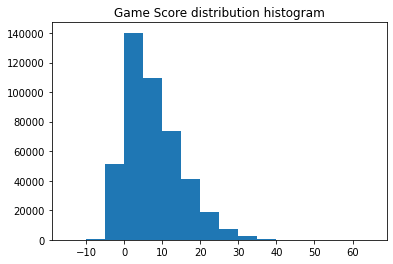

In [0]:
from matplotlib import pyplot as plt 
   
plt.hist(data_scores.flatten(), bins = [-15,-10,-5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65] ) 
plt.title("Game Score distribution histogram") 
plt.show()

In [0]:
# function for binning the data labels
def binning(data_scores):
  data_labels = data_scores.copy()
  for i in range(len(data_labels)):
    for j in range(len(data_labels[i])):
        if data_labels[i][j] < 0:
          data_labels[i][j] = 0
        elif data_labels[i][j] >= 0 and data_labels[i][j] < 10:
          data_labels[i][j] = 1
        elif data_labels[i][j] >= 10 and data_labels[i][j] < 20:
          data_labels[i][j] = 2
        elif data_labels[i][j] >= 20 and data_labels[i][j] < 30:
          data_labels[i][j] = 3
        elif data_labels[i][j] >= 30 and data_labels[i][j] < 800:
          data_labels[i][j] = 4
        elif data_labels[i][j] >= 800:
          data_labels[i][j] = 5

  return data_labels

In [0]:
# Binning TEST
print(f'The scores before binning:\n{data_scores}')
print(f'\nThe labels after binning:\n{binning(data_scores)}')

The scores before binning:
[[-2.10e+00  1.60e+01  1.65e+01 ...  2.34e+01 -1.60e+00  1.95e+01]
 [ 2.20e+00 -4.00e-01  3.10e+00 ...  1.60e+00  6.00e+00  1.19e+01]
 [ 5.40e+00 -1.30e+00  5.10e+00 ...  1.40e+01  1.29e+01  5.20e+00]
 ...
 [-9.00e-01  4.00e+00  3.20e+00 ...  3.00e-01  2.20e+00  8.00e-01]
 [-1.10e+00  4.00e-01 -5.00e-01 ...  2.70e+00  1.30e+00  2.00e-01]
 [-4.00e-01 -1.70e+00  1.00e+00 ...  2.10e+00  1.00e+03  1.00e+03]]

The labels after binning:
[[0. 2. 2. ... 3. 0. 2.]
 [1. 0. 1. ... 1. 1. 2.]
 [1. 0. 1. ... 2. 2. 1.]
 ...
 [0. 1. 1. ... 1. 1. 1.]
 [0. 1. 0. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 5. 5.]]


In [0]:
# Divide the score into bins
data_labels = binning(data_scores)

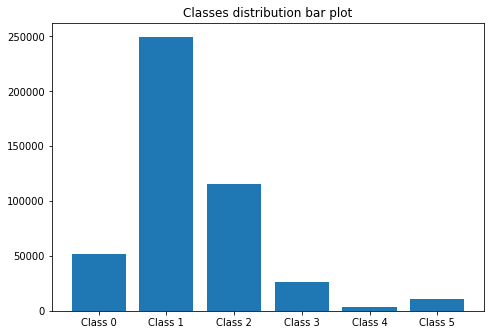

In [0]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bins = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
bins_count = np.bincount(data_labels.flatten().astype(int))
ax.bar(bins,bins_count)
plt.title("Classes distribution bar plot")
plt.show()

**Datasets Division**

After Pre-Processing our data and binning our labels we want to divide our dataset into 3 sets: train, validation and test.

We also want to split our sets into batches, for that we'll use TensorDataset and DataLoader.

In [0]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [0]:
def divide_dataset(data, labels, batch_size, train_portion = 0.8, validation_portion = 0.5):
  # divide data into train and test
  train_instances_number = int(train_portion * data.shape[0])

  train_data = data[:train_instances_number]
  train_labels = labels[:train_instances_number]

  test_valid_data = data[train_instances_number:]
  test_valid_labels = labels[train_instances_number:]

  # divide test data into test and validation
  valid_instances_number = int(VALIDATION_PORTION * test_valid_data.shape[0])

  test_data = test_valid_data[:valid_instances_number]
  test_labels = test_valid_labels[:valid_instances_number]
  
  valid_data = test_valid_data[valid_instances_number:]
  valid_labels = test_valid_labels[valid_instances_number:]

  # Wrap as datasets
  train_set = TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
  val_set = TensorDataset(torch.from_numpy(valid_data), torch.from_numpy(valid_labels))
  test_set = TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))
  
  # Wrap datasets with DataLoaders
  train_loader = DataLoader(train_set, batch_size=batch_size)
  val_loader = DataLoader(val_set, batch_size=batch_size)
  test_loader = DataLoader(test_set, batch_size=batch_size)
  
  return train_loader, val_loader, test_loader


In [0]:
# Dataset Division TEST
TRAIN_PORTION = 0.8
VALIDATION_PORTION = 0.5 # out of the test instances
BATCH_SIZE = 45

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')

print(f'Total number of instances: {data_sequences.shape[0]}')

batch_data, batch_labels = iter(train_loader).next()

print(f'Example data batch shape: {batch_data.shape}')
print(f'Example labels batch shape: {batch_labels.shape}')

Number of train instances:  36552
Number of validation instances:  4570
Number of test instances:  4569
Total number of instances: 45691
Example data batch shape: torch.Size([45, 10, 27])
Example labels batch shape: torch.Size([45, 10])


# **Defining our Network and preparing for Training**

Now we're finally at the point where we define our network.
we'll define a pretty simple LSTM Network which we will later experiment with in different settings.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# Model Definition
class NBAPredictionLSTM(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers,
                 dropout):
        
        super().__init__()
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers = n_layers, dropout = dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, sequence):

        #pass sequence into LSTM
        outputs, _ = self.lstm(sequence)
        
        #we use our outputs to make a prediction of what the tags should be
        predictions = self.fc(self.dropout(outputs))
        
        return predictions
    # Weight initialization from normal distribution
    def init_weights(self):
      for name, param in self.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)

In [0]:
# A function for measuring the accuracy of a model over a set of batches
def accuracy(model, loader):
  correct = 0
  total = 0

  model.eval()

  with torch.no_grad():
    for i, data in enumerate(loader):
      inputs, labels = data
      inputs = inputs.cuda().float()
      labels = labels.cuda().long()
      
      outputs = model(inputs)
      outputs = outputs.view(-1,5)
      labels = labels.view(-1)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return (correct / total) * 100

In [0]:
def train_epoch(model, loader, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for i, data in enumerate(loader, 0):
        # get inputs and put them on GPU
        inputs, labels = data

        inputs = inputs.cuda().float()
        labels = labels.cuda().long()
        
        optimizer.zero_grad()
        
        # Forward + reshape for loss function + backward + optimize
        outputs  = model(inputs)
        outputs = outputs.view(-1, 5) # reshape outputs from [batch_size, seq_len, output_size] -> [batch_size * seq_len, output_size]
        labels = labels.view(-1) # reshape labels from [batch_size, seq_len] -> [batch_size * seq_len]

        # back prop + optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accumulate epoch stats
        epoch_loss += loss.item()

    acc = accuracy(model, loader)
    return epoch_loss/len(loader), acc

In [0]:
def train_model(model, n_epochs, model_name):
  
  train_loss = 0
  train_acc = 0
  valid_acc = 0

  best_valid_acc = accuracy(model, val_loader)
  print(f'The accuracy of the model over the validation set before training: {best_valid_acc:.4}%')

  for epoch in range(n_epochs):
      
      train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
      valid_acc = accuracy(model, val_loader)
      
      if valid_acc > best_valid_acc:
          best_valid_acc = valid_acc
          torch.save(model.state_dict(), model_name)
      
      print(f'Epoch {epoch+1:02} Summary:')
      print(f'\t\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
      print(f'\t\tVal. Acc: {valid_acc:.2f}%')

  return  train_loss, train_acc, valid_acc

# **Experimenting with our Network**

After defining our network and laying the ground for training we'll start experimenting with it by using it in different settings.

We want to check our hpyothesis - a LSTM is well suited for predicting successive game scores.

In order to test this hypothesis we'll run 3 experiments:


1.   **Mini Batch Size** - First, we'll try to determine the best batch size for training
2.   **Sequence Length Size** - Next, we'll try to determine the best sequence length to use
3.   **Feed Forward Comparison** - Finally, we'll build a simple Feed Forward Network and compare it's performance to our LSTM model



**Experiment #1**

Best Batch Size out of: [16, 32, 64]



MODEL:

*   Sequence Length: 10 games
*   Hidden Dim: 128
*   Number of LSTM Layers: 2
*   Dropout probability: 0.25
*   Learning Rate: 0.005









**Batch Size = 16**

In [0]:
data_sequences, data_scores = pre_process_data(stats.values(), 10)
data_labels = binning(data_scores)

TRAIN_PORTION = 0.8
VALIDATION_PORTION = 0.5 # out of the test instances
BATCH_SIZE = 16

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {data_sequences.shape[0]}')

Number of train instances:  36552
Number of validation instances:  4570
Number of test instances:  4569
Total number of instances: 45691


In [0]:
# Create a model

PAD_INDEX = 5
INPUT_DIM = 27
HIDDEN_DIM = 128
OUTPUT_DIM = 5
N_LAYERS = 2
DROPOUT = 0.25
LEARNING_RATE=0.005

batch_test_model_1 = NBAPredictionLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(batch_test_model_1.parameters(), lr=LEARNING_RATE)
batch_test_model_1.init_weights()

In [0]:
# Train the Model
batch_train_loss_1, batch_train_acc_1, batch_val_acc_1 = train_model(batch_test_model_1, 10, 'NBA-LSTM-V1.pt')

The accuracy of the model over the validation set before training: 12.24%
Epoch 01 Summary:
		Train Loss: 0.997 | Train Acc: 55.43%
		Val. Acc: 54.56%
Epoch 02 Summary:
		Train Loss: 0.982 | Train Acc: 56.68%
		Val. Acc: 55.79%
Epoch 03 Summary:
		Train Loss: 0.978 | Train Acc: 57.87%
		Val. Acc: 56.95%
Epoch 04 Summary:
		Train Loss: 0.975 | Train Acc: 57.69%
		Val. Acc: 56.71%
Epoch 05 Summary:
		Train Loss: 0.974 | Train Acc: 57.87%
		Val. Acc: 56.96%
Epoch 06 Summary:
		Train Loss: 0.973 | Train Acc: 58.19%
		Val. Acc: 57.17%
Epoch 07 Summary:
		Train Loss: 0.972 | Train Acc: 58.32%
		Val. Acc: 57.26%
Epoch 08 Summary:
		Train Loss: 0.970 | Train Acc: 58.32%
		Val. Acc: 57.31%
Epoch 09 Summary:
		Train Loss: 0.970 | Train Acc: 58.40%
		Val. Acc: 57.29%
Epoch 10 Summary:
		Train Loss: 0.969 | Train Acc: 58.34%
		Val. Acc: 57.23%


In [0]:
batch_test_acc_1 = accuracy(batch_test_model_1, test_loader)
print(f"This model's accuracy over the Test set: {batch_test_acc_1:.4}%")
print(f"This model's average accuracy over the Train set: {batch_train_acc_1:.4}%")
print(f"This model's average accuracy over the Validation set: {batch_val_acc_1:.4}%")

This model's accuracy over the Test set: 59.46%
This model's average accuracy over the Train set: 58.34%
This model's average accuracy over the Validation set: 57.23%


**Batch Size = 32**

In [0]:
BATCH_SIZE = 32

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {data_sequences.shape[0]}')

Number of train instances:  36552
Number of validation instances:  4570
Number of test instances:  4569
Total number of instances: 45691


In [0]:
# Create a model
batch_test_model_2 = NBAPredictionLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(batch_test_model_2.parameters(), lr=LEARNING_RATE)
batch_test_model_2.init_weights()

In [0]:
batch_train_loss_2, batch_train_acc_2, batch_val_acc_2 = train_model(batch_test_model_2, 10, 'NBA-LSTM-V2.pt')

The accuracy of the model over the validation set before training: 20.73%
Epoch 01 Summary:
		Train Loss: 0.998 | Train Acc: 57.73%
		Val. Acc: 56.77%
Epoch 02 Summary:
		Train Loss: 0.980 | Train Acc: 58.20%
		Val. Acc: 57.26%
Epoch 03 Summary:
		Train Loss: 0.973 | Train Acc: 58.35%
		Val. Acc: 57.21%
Epoch 04 Summary:
		Train Loss: 0.972 | Train Acc: 58.42%
		Val. Acc: 57.23%
Epoch 05 Summary:
		Train Loss: 0.970 | Train Acc: 58.41%
		Val. Acc: 57.26%
Epoch 06 Summary:
		Train Loss: 0.969 | Train Acc: 58.44%
		Val. Acc: 57.26%
Epoch 07 Summary:
		Train Loss: 0.968 | Train Acc: 58.46%
		Val. Acc: 57.26%
Epoch 08 Summary:
		Train Loss: 0.967 | Train Acc: 58.48%
		Val. Acc: 57.30%
Epoch 09 Summary:
		Train Loss: 0.966 | Train Acc: 58.53%
		Val. Acc: 57.30%
Epoch 10 Summary:
		Train Loss: 0.966 | Train Acc: 58.49%
		Val. Acc: 57.43%


In [0]:
batch_test_acc_2 = accuracy(batch_test_model_2, test_loader)
print(f"This model's accuracy over the Test set: {batch_test_acc_2:.4}%")
print(f"This model's average accuracy over the Train set: {batch_train_acc_2:.4}%")
print(f"This model's average accuracy over the Validation set: {batch_val_acc_2:.4}%")

This model's accuracy over the Test set: 59.53%
This model's average accuracy over the Train set: 58.49%
This model's average accuracy over the Validation set: 57.43%


**Batch Size = 64**

In [0]:
BATCH_SIZE = 64

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {data_sequences.shape[0]}')

Number of train instances:  36552
Number of validation instances:  4570
Number of test instances:  4569
Total number of instances: 45691


In [0]:
# Create a model

batch_test_model_3 = NBAPredictionLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(batch_test_model_3.parameters(), lr=LEARNING_RATE)
batch_test_model_3.init_weights()

In [0]:
batch_train_loss_3, batch_train_acc_3, batch_val_acc_3 = train_model(batch_test_model_3, 10, 'NBA-LSTM-V3.pt')

The accuracy of the model over the validation set before training: 47.7%
Epoch 01 Summary:
		Train Loss: 0.996 | Train Acc: 58.13%
		Val. Acc: 57.15%
Epoch 02 Summary:
		Train Loss: 0.977 | Train Acc: 58.32%
		Val. Acc: 57.27%
Epoch 03 Summary:
		Train Loss: 0.972 | Train Acc: 58.39%
		Val. Acc: 57.33%
Epoch 04 Summary:
		Train Loss: 0.969 | Train Acc: 58.43%
		Val. Acc: 57.36%
Epoch 05 Summary:
		Train Loss: 0.967 | Train Acc: 58.45%
		Val. Acc: 57.31%
Epoch 06 Summary:
		Train Loss: 0.965 | Train Acc: 58.51%
		Val. Acc: 57.43%
Epoch 07 Summary:
		Train Loss: 0.964 | Train Acc: 58.49%
		Val. Acc: 57.34%
Epoch 08 Summary:
		Train Loss: 0.964 | Train Acc: 58.49%
		Val. Acc: 57.32%
Epoch 09 Summary:
		Train Loss: 0.963 | Train Acc: 58.54%
		Val. Acc: 57.38%
Epoch 10 Summary:
		Train Loss: 0.962 | Train Acc: 58.55%
		Val. Acc: 57.37%


In [0]:
batch_test_acc_3 = accuracy(batch_test_model_3, test_loader)
print(f"This model's accuracy over the Test set: {batch_test_acc_3:.4}%")
print(f"This model's average accuracy over the Train set: {batch_train_acc_3:.4}%")
print(f"This model's average accuracy over the Validation set: {batch_val_acc_3:.4}%")

This model's accuracy over the Test set: 59.58%
This model's average accuracy over the Train set: 58.55%
This model's average accuracy over the Validation set: 57.37%


**Experiment #2**

Best sequence length out of: [2, 4, 8, 16, 32]

MODEL:

*  Batch Size: 32
*  Hidden Dim: 128
*  Number of LSTM Layers: 2
*  Dropout probability: 0.25
*  Learning Rate: 0.005

**Sequnce Length = 2**

In [0]:
data_sequences, data_scores = pre_process_data(stats.values(), 2)
data_labels = binning(data_scores)

TRAIN_PORTION = 0.8
VALIDATION_PORTION = 0.5 # out of the test instances
BATCH_SIZE = 32

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {data_sequences.shape[0]}')

Number of train instances:  180235
Number of validation instances:  22530
Number of test instances:  22529
Total number of instances: 225294


In [0]:
# Create a model

PAD_INDEX = 5
INPUT_DIM = 27
HIDDEN_DIM = 128
OUTPUT_DIM = 5
N_LAYERS = 2
DROPOUT = 0.25
LEARNING_RATE=0.005

seq_test_model_1 = NBAPredictionLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(seq_test_model_1.parameters(), lr=LEARNING_RATE)
seq_test_model_1.init_weights()

In [0]:
seq_train_loss_1, seq_train_acc_1, seq_val_acc_1 = train_model(seq_test_model_1, 10, 'NBA-LSTM-Seq-V1.pt')

The accuracy of the model over the validation set before training: 52.52%
Epoch 01 Summary:
		Train Loss: 1.019 | Train Acc: 51.56%
		Val. Acc: 50.42%
Epoch 02 Summary:
		Train Loss: 1.003 | Train Acc: 53.92%
		Val. Acc: 52.91%
Epoch 03 Summary:
		Train Loss: 1.000 | Train Acc: 55.40%
		Val. Acc: 54.37%
Epoch 04 Summary:
		Train Loss: 1.000 | Train Acc: 54.95%
		Val. Acc: 53.79%
Epoch 05 Summary:
		Train Loss: 0.998 | Train Acc: 55.87%
		Val. Acc: 55.00%
Epoch 06 Summary:
		Train Loss: 0.997 | Train Acc: 57.18%
		Val. Acc: 56.34%
Epoch 07 Summary:
		Train Loss: 0.996 | Train Acc: 57.26%
		Val. Acc: 56.49%
Epoch 08 Summary:
		Train Loss: 0.996 | Train Acc: 57.18%
		Val. Acc: 56.28%
Epoch 09 Summary:
		Train Loss: 0.997 | Train Acc: 56.33%
		Val. Acc: 55.26%
Epoch 10 Summary:
		Train Loss: 0.996 | Train Acc: 56.74%
		Val. Acc: 55.71%


In [0]:
# Print Model's accuracy over Test Set
seq_test_acc_1 = accuracy(seq_test_model_1, test_loader)
print(f"This model's accuracy over the Test set: {seq_test_acc_1:.4}%")
print(f"This model's accuracy over the Train set: {seq_train_acc_1:.4}%")
print(f"This model's accuracy over the Validation set: {seq_val_acc_1:.4}%")

This model's accuracy over the Test set: 58.36%
This model's accuracy over the Train set: 56.74%
This model's accuracy over the Validation set: 55.71%


**Sequnce Length = 4**

In [0]:
data_sequences, data_scores = pre_process_data(stats.values(), 4)
data_labels = binning(data_scores)

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {data_sequences.shape[0]}')

Number of train instances:  90426
Number of validation instances:  11304
Number of test instances:  11303
Total number of instances: 113033


In [0]:
# Create a model

seq_test_model_2 = NBAPredictionLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(seq_test_model_2.parameters(), lr=LEARNING_RATE)
seq_test_model_2.init_weights()

In [0]:
seq_train_loss_2, seq_train_acc_2, seq_val_acc_2 = train_model(seq_test_model_2, 10, 'NBA-LSTM-Seq-V2.pt')

The accuracy of the model over the validation set before training: 10.27%
Epoch 01 Summary:
		Train Loss: 1.012 | Train Acc: 53.93%
		Val. Acc: 52.93%
Epoch 02 Summary:
		Train Loss: 0.993 | Train Acc: 56.78%
		Val. Acc: 55.78%
Epoch 03 Summary:
		Train Loss: 0.990 | Train Acc: 57.29%
		Val. Acc: 56.33%
Epoch 04 Summary:
		Train Loss: 0.988 | Train Acc: 57.89%
		Val. Acc: 56.91%
Epoch 05 Summary:
		Train Loss: 0.986 | Train Acc: 58.06%
		Val. Acc: 57.08%
Epoch 06 Summary:
		Train Loss: 0.985 | Train Acc: 58.17%
		Val. Acc: 57.17%
Epoch 07 Summary:
		Train Loss: 0.985 | Train Acc: 58.23%
		Val. Acc: 57.34%
Epoch 08 Summary:
		Train Loss: 0.984 | Train Acc: 58.31%
		Val. Acc: 57.38%
Epoch 09 Summary:
		Train Loss: 0.983 | Train Acc: 58.54%
		Val. Acc: 57.50%
Epoch 10 Summary:
		Train Loss: 0.983 | Train Acc: 58.49%
		Val. Acc: 57.46%


In [0]:
# Print Model's accuracy over Test Set
seq_test_acc_2 = accuracy(seq_test_model_2, test_loader)
print(f"This model's accuracy over the Test set: {seq_test_acc_2:.4}%")
print(f"This model's accuracy over the Train set: {seq_train_acc_2:.4}%")
print(f"This model's accuracy over the Validation set: {seq_val_acc_2:.4}%")

This model's accuracy over the Test set: 59.85%
This model's accuracy over the Train set: 58.49%
This model's accuracy over the Validation set: 57.46%


**Sequnce Length = 8**

In [0]:
data_sequences, data_scores = pre_process_data(stats.values(), 8)
data_labels = binning(data_scores)

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {data_sequences.shape[0]}')

Number of train instances:  45551
Number of validation instances:  5694
Number of test instances:  5694
Total number of instances: 56939


In [0]:
# Create a model

seq_test_model_3 = NBAPredictionLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(seq_test_model_3.parameters(), lr=LEARNING_RATE)
seq_test_model_3.init_weights()

In [0]:
seq_train_loss_3, seq_train_acc_3, seq_val_acc_3 = train_model(seq_test_model_3, 10, 'NBA-LSTM-Seq-V3.pt')

The accuracy of the model over the validation set before training: 10.78%
Epoch 01 Summary:
		Train Loss: 1.002 | Train Acc: 57.16%
		Val. Acc: 56.02%
Epoch 02 Summary:
		Train Loss: 0.984 | Train Acc: 57.77%
		Val. Acc: 56.84%
Epoch 03 Summary:
		Train Loss: 0.979 | Train Acc: 58.09%
		Val. Acc: 57.18%
Epoch 04 Summary:
		Train Loss: 0.975 | Train Acc: 58.34%
		Val. Acc: 57.47%
Epoch 05 Summary:
		Train Loss: 0.974 | Train Acc: 58.31%
		Val. Acc: 57.33%
Epoch 06 Summary:
		Train Loss: 0.973 | Train Acc: 58.46%
		Val. Acc: 57.51%
Epoch 07 Summary:
		Train Loss: 0.972 | Train Acc: 58.44%
		Val. Acc: 57.52%
Epoch 08 Summary:
		Train Loss: 0.971 | Train Acc: 58.43%
		Val. Acc: 57.50%
Epoch 09 Summary:
		Train Loss: 0.970 | Train Acc: 58.50%
		Val. Acc: 57.61%
Epoch 10 Summary:
		Train Loss: 0.970 | Train Acc: 58.56%
		Val. Acc: 57.71%


In [0]:
# Print Model's accurcy stats
seq_test_acc_3 = accuracy(seq_test_model_3, test_loader)
print(f"This model's accuracy over the Test set: {seq_test_acc_3:.4}%")
print(f"This model's accuracy over the Train set: {seq_train_acc_3:.4}%")
print(f"This model's accuracy over the Validation set: {seq_val_acc_3:.4}%")

This model's accuracy over the Test set: 57.25%
This model's accuracy over the Train set: 58.56%
This model's accuracy over the Validation set: 57.71%


**Sequnce Length = 16**

In [0]:
data_sequences, data_scores = pre_process_data(stats.values(), 16)
data_labels = binning(data_scores)

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {data_sequences.shape[0]}')

Number of train instances:  23099
Number of validation instances:  2888
Number of test instances:  2887
Total number of instances: 28874


In [0]:
seq_test_model_4 = NBAPredictionLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(seq_test_model_4.parameters(), lr=LEARNING_RATE)
seq_test_model_4.init_weights()

In [0]:
seq_train_loss_4, seq_train_acc_4, seq_val_acc_4 = train_model(seq_test_model_4, 10, 'NBA-LSTM-Seq-V4.pt')

The accuracy of the model over the validation set before training: 11.74%
Epoch 01 Summary:
		Train Loss: 0.995 | Train Acc: 57.60%
		Val. Acc: 56.52%
Epoch 02 Summary:
		Train Loss: 0.974 | Train Acc: 57.83%
		Val. Acc: 56.75%
Epoch 03 Summary:
		Train Loss: 0.969 | Train Acc: 57.88%
		Val. Acc: 56.76%
Epoch 04 Summary:
		Train Loss: 0.967 | Train Acc: 57.89%
		Val. Acc: 56.84%
Epoch 05 Summary:
		Train Loss: 0.965 | Train Acc: 57.95%
		Val. Acc: 56.85%
Epoch 06 Summary:
		Train Loss: 0.963 | Train Acc: 57.96%
		Val. Acc: 56.91%
Epoch 07 Summary:
		Train Loss: 0.962 | Train Acc: 57.95%
		Val. Acc: 56.95%
Epoch 08 Summary:
		Train Loss: 0.962 | Train Acc: 57.93%
		Val. Acc: 56.90%
Epoch 09 Summary:
		Train Loss: 0.961 | Train Acc: 58.02%
		Val. Acc: 56.91%
Epoch 10 Summary:
		Train Loss: 0.961 | Train Acc: 58.03%
		Val. Acc: 56.88%


In [0]:
# Print Model's accuracy over Test Set
seq_test_acc_4 = accuracy(seq_test_model_4, test_loader)
print(f"This model's accuracy over the Test set: {seq_test_acc_4:.4}%")
print(f"This model's accuracy over the Train set: {seq_train_acc_4:.4}%")
print(f"This model's accuracy over the Validation set: {seq_val_acc_4:.4}%")

This model's accuracy over the Test set: 57.18%
This model's accuracy over the Train set: 58.03%
This model's accuracy over the Validation set: 56.88%


**Sequnce Length = 32**

In [0]:
data_sequences, data_scores = pre_process_data(stats.values(), 32)
data_labels = binning(data_scores)

train_loader, val_loader, test_loader = divide_dataset(data_sequences, data_labels, BATCH_SIZE, TRAIN_PORTION, VALIDATION_PORTION)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {data_sequences.shape[0]}')

Number of train instances:  11900
Number of validation instances:  1488
Number of test instances:  1488
Total number of instances: 14876


In [0]:
seq_test_model_5 = NBAPredictionLSTM(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(seq_test_model_5.parameters(), lr=LEARNING_RATE)
seq_test_model_5.init_weights()

In [0]:
seq_train_loss_5, seq_train_acc_5, seq_val_acc_5 = train_model(seq_test_model_5, 10, 'NBA-LSTM-Seq-V4.pt')

The accuracy of the model over the validation set before training: 10.7%
Epoch 01 Summary:
		Train Loss: 0.990 | Train Acc: 56.34%
		Val. Acc: 55.15%
Epoch 02 Summary:
		Train Loss: 0.966 | Train Acc: 56.41%
		Val. Acc: 55.18%
Epoch 03 Summary:
		Train Loss: 0.960 | Train Acc: 56.42%
		Val. Acc: 55.20%
Epoch 04 Summary:
		Train Loss: 0.958 | Train Acc: 56.47%
		Val. Acc: 55.30%
Epoch 05 Summary:
		Train Loss: 0.956 | Train Acc: 56.50%
		Val. Acc: 55.22%
Epoch 06 Summary:
		Train Loss: 0.954 | Train Acc: 56.51%
		Val. Acc: 55.25%
Epoch 07 Summary:
		Train Loss: 0.953 | Train Acc: 56.50%
		Val. Acc: 55.29%
Epoch 08 Summary:
		Train Loss: 0.953 | Train Acc: 56.54%
		Val. Acc: 55.32%
Epoch 09 Summary:
		Train Loss: 0.952 | Train Acc: 56.52%
		Val. Acc: 55.21%
Epoch 10 Summary:
		Train Loss: 0.951 | Train Acc: 56.61%
		Val. Acc: 55.29%


In [0]:
# Print Model's accuracy over Test Set
seq_test_acc_5 = accuracy(seq_test_model_5, test_loader)
print(f"This model's accuracy over the Test set: {seq_test_acc_5:.4}%")
print(f"This model's accuracy over the Train set: {seq_train_acc_5:.4}%")
print(f"This model's accuracy over the Validation set: {seq_val_acc_5:.4}%")

This model's accuracy over the Test set: 57.31%
This model's accuracy over the Train set: 56.61%
This model's accuracy over the Validation set: 55.29%


**Experiment #3**

We now want to check if a regular Feed Forward Network performs better on the data.

In [0]:
class FFNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(FFNN, self).__init__()
        
        #TODO: Initialize parameters.
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,output_size)

        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, X):
        #TODO: Implement forward computation.
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        
        return X

In [0]:
ff_data = data_sequences.reshape(-1, 27)
ff_labels = data_labels.reshape(-1)

print(ff_data.shape)
print(ff_labels.shape)

train_loader, val_loader, test_loader = divide_dataset(ff_data, ff_labels, batch_size=64)

print(f'Number of train instances:  {len(train_loader.dataset)}')
print(f'Number of validation instances:  {len(val_loader.dataset)}')
print(f'Number of test instances:  {len(test_loader.dataset)}')
print(f'Total number of instances: {ff_data.shape[0]}')

(476032, 27)
(476032,)
Number of train instances:  380825
Number of validation instances:  47604
Number of test instances:  47603
Total number of instances: 476032


In [0]:
PAD_INDEX = 5
INPUT_DIM = 27
OUTPUT_DIM = 5
LEARNING_RATE=0.005

ff_model = FFNN(INPUT_DIM, OUTPUT_DIM).cuda()
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX) # ignore padding labels when calculating loss
optimizer = torch.optim.Adam(ff_model.parameters(), lr=LEARNING_RATE)

In [0]:
ff_train_loss, ff_train_acc, ff_val_acc = train_model(ff_model, 10, 'NBA-LSTM-Seq-V4.pt')

The accuracy of the model over the validation set before training: 11.65%
Epoch 01 Summary:
		Train Loss: 1.021 | Train Acc: 50.76%
		Val. Acc: 49.37%
Epoch 02 Summary:
		Train Loss: 0.996 | Train Acc: 52.43%
		Val. Acc: 50.81%
Epoch 03 Summary:
		Train Loss: 0.991 | Train Acc: 52.22%
		Val. Acc: 50.99%
Epoch 04 Summary:
		Train Loss: 0.992 | Train Acc: 52.47%
		Val. Acc: 51.10%
Epoch 05 Summary:
		Train Loss: 0.990 | Train Acc: 52.89%
		Val. Acc: 51.59%
Epoch 06 Summary:
		Train Loss: 0.989 | Train Acc: 54.59%
		Val. Acc: 53.43%
Epoch 07 Summary:
		Train Loss: 0.992 | Train Acc: 54.02%
		Val. Acc: 52.72%
Epoch 08 Summary:
		Train Loss: 0.990 | Train Acc: 52.77%
		Val. Acc: 51.39%
Epoch 09 Summary:
		Train Loss: 0.990 | Train Acc: 53.60%
		Val. Acc: 52.32%
Epoch 10 Summary:
		Train Loss: 0.989 | Train Acc: 52.98%
		Val. Acc: 51.76%


In [0]:
# Print Model's accuracy measures
ff_test_acc = accuracy(ff_model, test_loader)
print(f"This model's accuracy over the Test set: {ff_test_acc:.4}%")
print(f"This model's accuracy over the Train set: {ff_train_acc:.4}%")
print(f"This model's accuracy over the Validation set: {ff_val_acc:.4}%")

This model's accuracy over the Test set: 53.97%
This model's accuracy over the Train set: 52.98%
This model's accuracy over the Validation set: 51.76%


# **Conclusion**

After running several experiments it is quite clear that our approach is beneficial.

When we divide the data into sequences and run them through a sequential model, the results we get are better than the results a simple Feed Forward model was able to achieve:

**LSTM Model with sequnce length = 4**:
  * Test Accuracy = 59.85%
  * Train Accuracy = 58.49%
  * Validation Accuracy = 57.46%


**Feed Forward Model with 3 Fully Connected Layers**:
  * Test Accuracy: 53.97%
  * Train Accuracy: 52.98%
  * Validation Accuracy: 51.76%

